# Summarization with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new summarization capabilities to train, evaluate, and deploy a BART summarization model.

How to use blurr: https://ohmeow.com/posts/2020/05/23/text-generation-with-blurr.html

Installations:

In [ ]:
!pip install toml
!pip install pynvml
!pip install pyinspect

!pip install transformers -Uqq
!pip install datasets -Uqq
!pip install bert-score -Uqq
!pip install sacremoses
!pip install ohmeow-blurr -Uqq

!pip install rouge

!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 5.9 MB/s 
     |████████████████████████████████| 235 kB 35.7 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
     |████████████████████████████████| 4.4 MB 8.4 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 6.6 MB 2.5 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 362 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 37.9 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 212 kB 51.8 MB/s 
     |█████████

In [ ]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *
import rouge
from numba import cuda 
from pynvml import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

import nltk
nltk.download('punkt', quiet=True)

#connect to drive:
from google.colab import drive
drive.mount('/content/drive')

# # conncet hugging face:
# from huggingface_hub import notebook_login
# notebook_login()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
kaggle_dir = f"/content/drive/MyDrive/HIT/NLP/Final_Project/cnn_daily_mail_dataset/kaggle/cnn_dailymail"

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!nvidia-smi

Thu Jul 14 15:27:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |    767MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = cuda.get_current_device()
# device.reset()

In [ ]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
print_gpu_utilization()

GPU memory occupied: 2 MB.


# The model:

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

# Read data

In [ ]:
def read_orig_data(type, num_samples=-1):
  if num_samples > 0:
    return pd.read_csv(f'{kaggle_dir}/orig_data/{type}.csv', nrows=num_samples)
  else:
    return pd.read_csv(f'{kaggle_dir}/orig_data/{type}.csv')

def read_clean_data(type, num_samples=-1):
  if num_samples > 0:
    return pd.read_csv(f'{kaggle_dir}/clean_data/{type}.csv', nrows=num_samples)
  else:
    return pd.read_csv(f'{kaggle_dir}/clean_data/{type}.csv')

In [ ]:
# val_df = pd.read_csv(f'{kaggle_dir}/clean_data/validation.csv')
# clean_train_df = pd.read_csv(f'{kaggle_dir}/clean_data/train.csv')
# clean_test_df = pd.read_csv(f'{kaggle_dir}/clean_data/test.csv')

In [ ]:
TRAIN_VAL_NUM_SAMPLES = 75000
TEST_NUM_SAMPLES = 1000

def write_small_clean_df(df_type='train', num_samples=1000):
  train_df = read_clean_data(df_type, num_samples=num_samples)
  file_name = f'{df_type}_{num_samples}'
  train_df.to_csv(f'{kaggle_dir}/clean_data/{file_name}.csv', index=False)

# write_small_clean_df('train', TRAIN_VAL_NUM_SAMPLES)
# write_small_clean_df('test', TEST_NUM_SAMPLES)

Small Datasets:

In [ ]:
clean_train_df = pd.read_csv(f'{kaggle_dir}/clean_data/train_{TRAIN_VAL_NUM_SAMPLES}.csv')

In [ ]:
clean_test_df = pd.read_csv(f'{kaggle_dir}/clean_data/test_{TEST_NUM_SAMPLES}.csv')

## Data Preparation

In [ ]:
df = clean_train_df
df.head()

,article,highlights
0,"The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grvirus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, GrState Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Mon...","Bishop John Folda, of North Dakota, is taking time off after being diagnosed . He contracted the infection through contaminated food in Italy . Church members in Fargo, Grand Forks and Jamestown could have been exposed ."
1,"Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as ""The Milk Man,"" of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance,...","Criminal complaint: Cop used his role to help cocaine traffickers . Ralph Mata, an internal affairs lieutenant, allegedly helped group get guns . He also arranged to pay two assassins in a murder plot, a complaint alleges ."
2,"A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he received a text message. As he was reading or replying to it, he veered across the road while driving round a bend and smashed into Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27 (left) was using his mobile phone when he crashed head-on into the car being driven by Rachel Titley, 28 (right). She died later from her injuries . The head-on crash took place in October 2013. Mr Eccl...","Craig Eccleston-Todd, 27, had drunk at least three pints before driving car . Was using phone when he veered across road in Yarmouth, Isle of Wight . Crashed head-on into 28-year-old Rachel Titley's car, who died in hospital . Police say he would have been over legal drink-drive limit at time of crash . He was found guilty at Portsmouth Crown Court of causing death by dangerous driving ."
3,"With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prior, Ukraine's breakaway peninsula was signed away just as swiftly by Soviet leader Nikita Khrushchev. But dealing with such a blatant land grab on its eastern flank won't be anywhere near as quick and easy for Europe's 28-member union. Because, unlike Crimea's rushed referendum, everyone has a say. After initially slapping visa restrictions limited number of little known politicians and military men, Europe...","Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides . Targeting Russia's business community would be one way of sapping their support for President Putin, she says . But she says Europe would have a hard time keeping its factories going without power from the east ."
4,"Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier for the first time in their history after six promotions in nine years and their remarkable ascent shows no sign of slowing with Jamie Proctor and Gareth Evans scoring the goals at Glanford Park. Fleetwood were one of fiv

In [ ]:
df.shape

(75000, 2)

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

Next we need to build out our DataBlock. A DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization.  All we need is to define a single `Seq2SeqBatchTokenizeTransform` instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences.  In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with blurr, we can even customize the text generation by passing in `text_gen_kwargs`.

We pass `noop` as a type transform for our targets because everything is already handled by the batch transform now.

In [ ]:
MAX_ART_LEN = 256 # 256
MAX_SUM_LEN = 130

def build_data_blocks(df, hf_arch, hf_config, hf_model, hf_tokenizer, valid_pct=0.2):
  text_gen_kwargs = default_text_gen_kwargs(
      hf_config, hf_model, task='summarization')
  
  hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, 
    max_length=MAX_ART_LEN, max_tgt_length=MAX_SUM_LEN, 
    text_gen_kwargs=text_gen_kwargs
    )
  
  blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)
  dblock = DataBlock(blocks=blocks, get_x=ColReader('article'), 
                     get_y=ColReader('highlights'), splitter=RandomSplitter(valid_pct=valid_pct, seed=42))
  
  dls = dblock.dataloaders(df, bs=2)

  return dls

In [ ]:
dls = build_data_blocks(df, hf_arch, hf_config, hf_model, hf_tokenizer, valid_pct=0.02)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(73500, 1500)

Check out a batch of data' shapes:

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 87]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.  We pass in the `dls` via the `dataloaders` argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> A chemical used to make yoga mats has been found in almost 500 food items, according to a study released this week. The compound azodicarbonamide (ADA) is typically used in bread products to bleach flour and make the dough stronger while keeping it light and spongy. The additive is also an ingredient of shoe rubber and attic insulation, according to research released on Thursday by The Environmental Working Group (EWG). ADA features in foods made by at least 130 American brands including Jimmy Dean, Sara Lee, Pillsbury, White Castle, Marie Calledar's and Country Hearth. Scroll down for video. What's on your plate? A chemical called azodicarbonamide (ADA) which is used to make yoga mats (left) has also been found in close to 500 food products including many 'healthy' breads, salad croutons and fruit strudels (right) Most of the items which contain ADA are bread, pre-made sandwiches, croutons and snacks. According to EWG, the synthetic additive has not been a problem for the federal Food because the low levels of 45 parts per million are not known to be toxic. However a study by the World Health Organization showed that when handed in large quantities, the chemical causes respiratory problems including</s>","Chemical compound azodicarbonamide (ADA) is used in foods made by big brands including Jimmy Dean, Sara Lee, Pillsbury, White Castle, Marie Calledar's and Country Hearth. ADA is banned in the UK, most European countries and Australia. Subway announced last month they would no longer use ingredient at their U.S. sandwich chains. In large quantities, ADA can cause respiratory problems and skin irritations."
1,"<s> Britain's most senior Catholic cleric - Cardinal Keith O'Brien - stands alongside his long-standing friend, Jimmy Savile. Pictured giving a thumbs-up, he is seen grinning alongside the paedophile at a fund-raising event in Edinburgh six years ago. The former leader of Scotland’s Catholics stepped down yesterday amid accuations of 'inappropriate acts' towards fellow priests. He strongly denies all claims against him. Cardinal Keith O’Brien was among many high-powered supporters of Savile who did not know about the entertainer’s sexual abuse of children. Scroll down for video. Friends: Jimmy Savile, left, and Cardinal Keith O'Brien were pictured together in Edinburgh in 2007 as the pair unveiled a £375,000 vehicle for the disabled. Resigned: The cardinal, who stepped down yesterday, was seen looking out of a window at his home in Edinburgh, Scotland, today. He met the former DJ fundraiser in the 1970s when O’Brien was a priest in Kilsyth, north. Lanarkshire, friend of Savile’s mother. They were pictured together in Scotland in 2007 as the pair unveiled a £375,000 vehicle for the disabled. When the Savile scandal emerged, the</s>","Cardinal Keith O'Brien faces claims of inappropriate attention by four priests. One unnamed priest alleges 'unwanted behaviour' after late-night drinking. Another unnamed priest said he was 18 when 'inappropriately approached' O'Brien, 74, steps down as Archbishop of St Andrew's and Edinburgh today. Will no longer travel to Rome to help elect successor to Pope Benedict XVI."


# Prepare for Training

We'll prepare our BART model for training by wrapping it in blurr's `BaseModelWrapper` object and using the callback, `BaseModelCallback`, as usual.  A new `Seq2SeqMetricsCallback` object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  

In [ ]:
def create_learner(hf_model, hf_arch, dls):
  seq2seq_metrics = {
          'rouge': {
              'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
              'returns': ["rouge1", "rouge2", "rougeL"]
          },
          'bertscore': {
              'compute_kwargs': { 'lang': 'en' },
              'returns': ["precision", "recall", "f1"]
          }
      }
  
  model = BaseModelWrapper(hf_model)
  learn_cbs = [BaseModelCallback]
  fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

  learn = Learner(dls, 
                  model,
                  opt_func=ranger,
                  loss_func=CrossEntropyLossFlat(),
                  cbs=learn_cbs,
                  splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()
  return learn

In [ ]:
learn = create_learner(hf_model, hf_arch, dls)

learn.create_opt() 
learn.freeze()

We're only going to train the frozen model for one epoch for this demo.

Try getting good start for learning-rate:

SuggestedLRs(minimum=0.00012022644514217973, steep=1.9054607491852948e-06, valley=0.00013182566908653826, slide=7.585775892948732e-05)

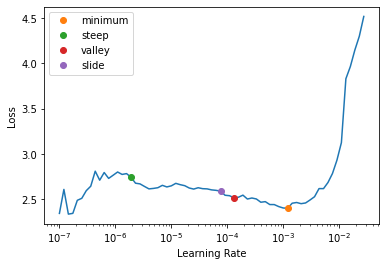

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

We'll run a batch through our model and make sure the shape of what goes in, and comes out, looks right:

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(2.6833, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([2, 107, 50264]))

We can actually do some training using Fast.ai’s fit_one_cycle() method. We will just do one epoch for the sake of time, this is also where we will pass in those metrics callback that we covered above.

We tried first to check if the model cn learn. Our experiment included: <br>
Data sizes: train set = 10, test set = 1 <br>
Epocs: 20 <br>
Results: train loss = 0.75, test validation loss = 2.63<br>
<br>
Consclusions: <br>
1) By small data, we got overfitting as expected. Which means - the model really learned from the training' process. <br>



# Training

In [ ]:
NUM_EPOCS = 1
# learn.fit_one_cycle(NUM_EPOCS, lr_max=3e-5, cbs=fit_cbs)

After single epoch we got: train loss 1.708, val loss 1.715, rouge 1: 0.41, rouge 2: 0.19, rouge L: 0.285

Load fine-tuned model we already trained, from google drive:

In [ ]:
model_name = f"ft_cnndm_export_{NUM_EPOCS}_EPOCH_{TRAIN_VAL_NUM_SAMPLES}"
models_dir = f"{kaggle_dir}/models/bart"
inf_learn = load_learner(fname=f'{models_dir}/{model_name}.pkl', cpu=False)

Push our model into HuggingFace (model + configuration + tokenizer):

In [ ]:
repo_id = "Aviv/Moran_Aviv_Bart"

In [ ]:
# from huggingface_hub import push_to_hub_fastai
# push_to_hub_fastai(learner=inf_learn, repo_id=repo_id)
# hf_tokenizer.save_pretrained("https://huggingface.co/Aviv/Moran_Aviv_Bart/", push_to_hub=True)

Get our model from hugging face:

In [ ]:
# from huggingface_hub import from_pretrained_fastai
# inf_learn = from_pretrained_fastai(repo_id)
# if (torch.cuda.is_available()):
#   inf_learn.to(device="cuda:0")

In [ ]:
inf_learn.blurr_summarize(clean_test_df['article'][0])

[{'summary_texts': " Consumer advisory group set up by Department of Transportation says shrinking space on planes is putting our health and safety in danger . Tests conducted by the FAA use planes with a 31 inch pitch, a stMany economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches . British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31."}]

# Evaluate

In [ ]:
def evaluate_avg_rouge(summary_corpus, pred_summary_corpus):
    assert len(summary_corpus) == len(pred_summary_corpus), f"summary and predicted summary have no same length: {len(summary_corpus)}, {len(pred_summary_corpus)}"
    assert len(summary_corpus) > 0, f"num of summaries is 0!"
    if type(summary_corpus) is str:
        summary_corpus = [summary_corpus]
    if type(pred_summary_corpus) is str:
        pred_summary_corpus = [pred_summary_corpus]

    avg_scores = {'rouge-1': 0, 'rouge-2': 0, 'rouge-L': 0}

    rouge_obj = rouge.Rouge()
    for (txt, pred_txt) in zip(summary_corpus, pred_summary_corpus):
        if pred_txt=='':
            score_1 = 0
            score_2 = 0
            score_L = 0
        else:
            scores = rouge_obj.get_scores(refs=txt, hyps=pred_txt, avg=True)
            score_1 = round(scores['rouge-1']['f'], 3)
            score_2 = round(scores['rouge-2']['f'], 3)
            score_L = round(scores['rouge-l']['f'], 3)

        avg_scores['rouge-1'] = avg_scores['rouge-1'] + score_1
        avg_scores['rouge-2'] = avg_scores['rouge-2'] + score_2
        avg_scores['rouge-L'] = avg_scores['rouge-L'] + score_L

    avg_scores['rouge-1'] = round(avg_scores['rouge-1'] / len(summary_corpus), 2)
    avg_scores['rouge-2'] = round(avg_scores['rouge-2'] / len(summary_corpus), 2)
    avg_scores['rouge-L'] = round(avg_scores['rouge-L'] / len(summary_corpus), 2)
    return avg_scores

In [ ]:
test_df = pd.read_csv(f'{kaggle_dir}/clean_data/test_1000.csv')

In [ ]:
test_df['article'].shape

(1000,)

In [ ]:
def save_predictions(df, learner, save_each=50):
  pred_summaries = []

  for ind, article in enumerate(df['article']):
    outputs = learner.blurr_summarize(df['article'][ind], early_stopping=True, num_beams=4)
    pred_summaries.append(outputs[0]['summary_texts'][0])

    if ((ind+1) % 10 == 0):
      print(f'finished article {ind}')
    if ((ind+1) % save_each == 0):
      pred_summaries_np = np.array(pred_summaries)
      pred_summary_df = pd.DataFrame({"pred_summary": pred_summaries_np})
      pred_summary_df.to_csv(f'{kaggle_dir}/bart_test_preds/test_bart_pred_{ind-(save_each-1)}_{ind}.csv')

# # takes long time: ~hour
# save_predictions(test_df, inf_learn)

In [ ]:
pred_summary_corpus = pred_summaries
summary_corpus = test_df['highlights']

The evaluation on Bart for test-set is: <br>
'rouge-1': 0.4, 'rouge-2': 0.18, 'rouge-L': 0.37

In [ ]:
evaluate_avg_rouge(summary_corpus, pred_summary_corpus)

{'rouge-1': 0.4, 'rouge-2': 0.18, 'rouge-L': 0.37}

In [ ]:
pred_summaries[1]

" Rahul Kumar, 17, climbed into enclosure at\xa0Kamla Nehru Zoological Park in Ahmedabad . He ran towards the animals shouting: 'Today I kill a lion or a lion kills me!' Fortunately, he fell into a moat and was rescued by zoo security before reaching the animals . He has been cautioned and will be sent for psychiatric evaluation by police ."

In [ ]:
train_article = clean_train_df['article'][0]
train_summary = clean_train_df['highlights'][0]

In [ ]:
outputs = learn.blurr_summarize(train_article, early_stopping=True, num_beams=4)
pred_summary = outputs[0]['summary_texts']
# for idx, o in enumerate(outputs):
#     print(f'=== Prediction {idx+1} ===\n{o}\n')

In [ ]:
train_summary

In [ ]:
pred_summary[0]

' Bishop John Folda of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo . The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion . The diocese announced on Monday that Bishop Folda is taking time off after being diagnosed with hepatitis A . He contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month .'

And now we can look at the generated predictions using our `text_gen_kwargs` above

In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"David Moyes' first home game as the new Manchester United manager will be against Jose Mourinho's Chelsea. Barclays Premier League champions United face a nightmare start to the 2013-14 season with trips to bitter rivals Liverpool and Manchester City in the opening five games. United begin at League Cup winners Swansea on August 17, before the returning Mourinho's Chelsea visit Old Trafford the following weekend. A match at Liverpool follows for United on August 31 before a visit to City in the fifth game of the season on September 21. Scroll down for all the 2013/14 Barclays Premier League and club-by-club fixtures. Arsenal v Aston Villa. Chelsea v Hull City. Crystal Palace v Tottenham Hotspur. Liverpool v Stoke City. Manchester City v Newcastle United. Norwich City v Everton. SunderlSwansea City v Manchester United. West Bromwich Albion v Southampton. West Ham United v Cardiff City. Champions: Man United will look to successfully defend their title this season under new boss David Moyes. Baptism of fire: Moyes faces Chelsea Mourinho's men kick off the campaign. with a match against newly-promoted Hull at Stamford Bridge, while there. are also home games for fellow Champions League hopefuls Manchester. City and Arsenal. Manuel Pellegrini's reign","Premier League fixtures for 2013-14 season announced. Man United face Chelsea, Liverpool and Man City in opening five games. Play-off winners Crystal Palace start with London derby at home to Spurs.","[ David Moyes' first home game as Manchester United manager will be against Jose Mourinho's Chelsea . Moyes takes over from Louis van Gaal after the Scot's sacking as United boss in July . Premier League champions face Chelsea, Liverpool and Man City in opening five games of 2013-14 campaign . United begin at League Cup winners Swansea on August 17, before returning Mourinho's Blues visit Old Trafford . A match at Liverpool follows for United on August 31 before a visit to City in the fifth game on September 21 ., Terrorists entered Algeria from Libya with members of 'Blood Battalion' led by Mokhtar Belmokhtar . Survivors say at least one of the kidnappers spoke perfect English in giving orders . Terrorists' weapons recovered by Algerian special forces included six machine guns, 21 rifles, two mortars with shells, two rocket-propelled grenade launchers and machine guns .]"


Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
# test_article = """
# The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline 
# crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
# """

Let's try it on an aricle from the test dataframe:

In [ ]:
test_article = clean_test_df['article'][0]

In [ ]:
test_article

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for space in the over

We can override the `text_gen_kwargs` we specified for our `DataLoaders` when we generate text using blurr's `Learner.blurr_generate` method

In [ ]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
{'summary_texts': ["U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a stMany economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches.", "U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch.", "U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Some ec

In [ ]:
outputs

[{'summary_texts': ["U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a stMany economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches.",
   "U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch.",
   "U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Some economy seats on

What about inference?

In [ ]:
inf_learn.blurr_summarize(test_article)

[{'summary_texts': " Consumer advisory group set up by Department of Transportation says shrinking space on planes is putting our health and safety in danger . Tests conducted by the FAA use planes with a 31 inch pitch, a stMany economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches . British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31."}]

In [ ]:
clean_test_df['highlights'][0]

'Experts question if  packed out planes are putting passengers at risk . U.S consumer advisory group says minimum space must be stipulated . Safety tests conducted on planes with more leg room than airlines offer .'

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to summarization (e.g., sequence classification , token classification, and question/answering, causal language modeling, and transation). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!